# I/O Benchmarking: Network and Local Storage

## Test Scenarios

1. **Network → Network**: Read from `\\rbo-s1`, write back to `\\rbo-s1`
2. **Network → Local**: Read from `\\rbo-s1`, write to local NVMe (`RBO-W2 @ D://demo//staging`)
3. **Local → Local**: Copy to local first, then read/write locally
4. **Parameter Effects**: Test parameters (fix_phase, use_fft, register_z, compression, sharding, file-size)

## Key Questions

- Is it faster to extract directly to network or local storage?
- Does copying raw files to local storage first improve total workflow time?
- How much do processing parameters affect I/O vs computation time?
- Which file format (`.bin`, `.tiff`, `.zarr`) is fastest for each scenario?

In [1]:
# Imports
from pathlib import Path
import numpy as np
import time
import shutil
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mbo_utilities as mbo

## Configuration

In [2]:
# Storage paths
NETWORK_PATH = Path(r"\\rbo-s1\S1_DATA\lbm\demo_user")
LOCAL_PATH = Path(r"D:\demo\staging")

# Source data
RAW_TIFFS_NETWORK = NETWORK_PATH / "raw_scanimage_tiffs"
RAW_TIFFS_LOCAL = LOCAL_PATH / "raw_scanimage_tiffs"

# Output directories
OUTPUT_NETWORK = NETWORK_PATH / "benchmark_output"
OUTPUT_LOCAL = LOCAL_PATH / "benchmark_output"

# Create directories
LOCAL_PATH.mkdir(parents=True, exist_ok=True)
RAW_TIFFS_LOCAL.mkdir(parents=True, exist_ok=True)
OUTPUT_NETWORK.mkdir(parents=True, exist_ok=True)
OUTPUT_LOCAL.mkdir(parents=True, exist_ok=True)

print(f"Network path: {NETWORK_PATH}")
print(f"Local path: {LOCAL_PATH}")
print(f"Network path exists: {NETWORK_PATH.exists()}")
print(f"Local path exists: {LOCAL_PATH.exists()}")

Network path: \\rbo-s1\S1_DATA\lbm\demo_user
Local path: D:\demo\staging
Network path exists: True
Local path exists: True


## Test Parameters

Define different parameter combinations to test

In [3]:
# File formats to test
FILE_FORMATS = ['.bin', '.tiff', '.zarr']

# Processing parameter sets
PARAM_SETS = {
    'minimal': {
        'fix_phase': False,
        'use_fft': False,
        'register_z': False,
        'description': 'No processing (fastest)'
    },
    'phase_only': {
        'fix_phase': True,
        'use_fft': False,
        'register_z': False,
        'description': 'Scan-phase correction only'
    },
    'phase_fft': {
        'fix_phase': True,
        'use_fft': True,
        'register_z': False,
        'description': 'FFT scan-phase correction'
    },
    'full': {
        'fix_phase': True,
        'use_fft': True,
        'register_z': True,
        'description': 'Full processing pipeline'
    }
}

# Subset of planes to extract (for faster testing)
TEST_PLANES = [6, 7, 8]  # Test with 3 planes
TEST_FRAMES = 1000  # Number of frames to extract

print("Parameter sets to test:")
for name, params in PARAM_SETS.items():
    print(f"  {name}: {params['description']}")
print(f"\nFile formats: {FILE_FORMATS}")
print(f"Test planes: {TEST_PLANES}")
print(f"Test frames: {TEST_FRAMES}")

Parameter sets to test:
  minimal: No processing (fastest)
  phase_only: Scan-phase correction only
  phase_fft: FFT scan-phase correction
  full: Full processing pipeline

File formats: ['.bin', '.tiff', '.zarr']
Test planes: [6, 7, 8]
Test frames: 1000


## Utility Functions

In [4]:
def get_directory_size(path):
    """Calculate total size of directory in MB"""
    total_size = 0
    for item in Path(path).rglob('*'):
        if item.is_file():
            total_size += item.stat().st_size
    return total_size / (1024 * 1024)  # Convert to MB

def time_operation(func, *args, **kwargs):
    """Time a function execution"""
    start_time = time.time()
    result = func(*args, **kwargs)
    elapsed_time = time.time() - start_time
    return result, elapsed_time

def copy_files_timed(src, dst):
    """Copy files and return time taken"""
    start_time = time.time()
    if dst.exists():
        shutil.rmtree(dst)
    shutil.copytree(src, dst)
    elapsed_time = time.time() - start_time
    size_mb = get_directory_size(dst)
    return elapsed_time, size_mb

def cleanup_output(path):
    """Clean up output directory"""
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

print("Utility functions loaded")

Utility functions loaded


## Benchmark 1: Network → Network

Read from network storage, write back to network storage

In [5]:
results_network_to_network = []

# Get raw files
raw_files = mbo.get_files(RAW_TIFFS_NETWORK)
print(f"Found {len(raw_files)} TIFF files on network")

for param_name, param_set in PARAM_SETS.items():
    for file_format in FILE_FORMATS:
        print(f"\nTesting: {param_name} → {file_format}")

        # Clean output directory
        test_output = OUTPUT_NETWORK / f"net2net_{param_name}"
        cleanup_output(test_output)

        try:
            # Load scan
            scan = mbo.imread(raw_files)
            scan.roi = None
            scan.fix_phase = param_set['fix_phase']
            scan.use_fft = param_set['use_fft']

            # Time the write operation
            start_time = time.time()
            mbo.imwrite(
                scan,
                test_output,
                ext=file_format,
                num_frames=TEST_FRAMES,
                planes=TEST_PLANES,
                overwrite=True,
                register_z=param_set['register_z']
            )
            elapsed_time = time.time() - start_time

            # Get output size
            output_size = get_directory_size(test_output)

            # Calculate throughput
            throughput = output_size / elapsed_time if elapsed_time > 0 else 0

            results_network_to_network.append({
                'scenario': 'Network → Network',
                'params': param_name,
                'format': file_format,
                'time_sec': elapsed_time,
                'size_mb': output_size,
                'throughput_mb_per_sec': throughput,
                'success': True
            })

            print(f"  Time: {elapsed_time:.2f}s, Size: {output_size:.2f}MB, Throughput: {throughput:.2f}MB/s")

        except Exception as e:
            print(f"  ERROR: {e}")
            results_network_to_network.append({
                'scenario': 'Network → Network',
                'params': param_name,
                'format': file_format,
                'time_sec': None,
                'size_mb': None,
                'throughput_mb_per_sec': None,
                'success': False,
                'error': str(e)
            })

df_net2net = pd.DataFrame(results_network_to_network)
print("\n" + "="*80)
print("Network → Network Results:")
print(df_net2net[df_net2net['success']])

Found 50 TIFF files on network

Testing: minimal → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 10.70s, Size: 1148.50MB, Throughput: 107.31MB/s

Testing: minimal → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 7.05s, Size: 1149.30MB, Throughput: 162.91MB/s

Testing: minimal → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 65.76s, Size: 46.32MB, Throughput: 0.70MB/s

Testing: minimal → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 6.61s, Size: 1148.72MB, Throughput: 173.71MB/s

Testing: phase_only → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 9.35s, Size: 1148.50MB, Throughput: 122.81MB/s

Testing: phase_only → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 7.27s, Size: 1149.30MB, Throughput: 157.99MB/s

Testing: phase_only → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 58.51s, Size: 46.32MB, Throughput: 0.79MB/s

Testing: phase_only → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 7.87s, Size: 1148.72MB, Throughput: 145.95MB/s

Testing: phase_fft → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 40.29s, Size: 1148.50MB, Throughput: 28.50MB/s

Testing: phase_fft → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 36.81s, Size: 1149.30MB, Throughput: 31.23MB/s

Testing: phase_fft → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 93.35s, Size: 46.47MB, Throughput: 0.50MB/s

Testing: phase_fft → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 37.43s, Size: 1148.72MB, Throughput: 30.69MB/s

Testing: full → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.50 sec
    Workers completed in 1.56 sec
    Total time: 2.06 sec


Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 66.25s, Size: 3144.30MB, Throughput: 47.46MB/s

Testing: full → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.48 sec
    Workers completed in 1.55 sec
    Total time: 2.03 sec


Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 63.53s, Size: 3445.01MB, Throughput: 54.23MB/s

Testing: full → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.48 sec
    Workers completed in 1.57 sec
    Total time: 2.04 sec


Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 114.86s, Size: 2042.33MB, Throughput: 17.78MB/s

Testing: full → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.48 sec
    Workers completed in 1.59 sec
    Total time: 2.07 sec


Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 62.04s, Size: 3444.43MB, Throughput: 55.52MB/s

Network → Network Results:
             scenario      params format    time_sec      size_mb  \
0   Network → Network     minimal   .bin   10.702283  1148.503850   
1   Network → Network     minimal  .tiff    7.054777  1149.296391   
2   Network → Network     minimal  .zarr   65.760665    46.324299   
3   Network → Network     minimal    .h5    6.612663  1148.716782   
4   Network → Network  phase_only   .bin    9.352152  1148.503976   
5   Network → Network  phase_only  .tiff    7.274649  1149.296345   
6   Network → Network  phase_only  .zarr   58.513951    46.324764   
7   Network → Network  phase_only    .h5    7.870361  1148.716782   
8   Network → Network   phase_fft   .bin   40.294002  1148.503970   
9   Network → Network   phase_fft  .tiff   36.805273  1149.296345   
10  Network → Network   phase_fft  .zarr   93.354892    46.465253   
11  Network → Network   phase_fft    .h5   37.425199  1148.716782   
12  Network → Networ

## Benchmark 2: Network → Local

Read from network storage, write to local NVMe

In [6]:
results_network_to_local = []

for param_name, param_set in PARAM_SETS.items():
    for file_format in FILE_FORMATS:
        print(f"\nTesting: {param_name} → {file_format}")

        # Clean output directory
        test_output = OUTPUT_LOCAL / f"net2local_{param_name}"
        cleanup_output(test_output)

        try:
            # Load scan from network
            scan = mbo.imread(raw_files)
            scan.roi = None
            scan.fix_phase = param_set['fix_phase']
            scan.use_fft = param_set['use_fft']

            # Time the write operation to local
            start_time = time.time()
            mbo.imwrite(
                scan,
                test_output,
                ext=file_format,
                num_frames=TEST_FRAMES,
                planes=TEST_PLANES,
                overwrite=True,
                register_z=param_set['register_z']
            )
            elapsed_time = time.time() - start_time

            # Get output size
            output_size = get_directory_size(test_output)

            # Calculate throughput
            throughput = output_size / elapsed_time if elapsed_time > 0 else 0

            results_network_to_local.append({
                'scenario': 'Network → Local',
                'params': param_name,
                'format': file_format,
                'time_sec': elapsed_time,
                'size_mb': output_size,
                'throughput_mb_per_sec': throughput,
                'success': True
            })

            print(f"  Time: {elapsed_time:.2f}s, Size: {output_size:.2f}MB, Throughput: {throughput:.2f}MB/s")

        except Exception as e:
            print(f"  ERROR: {e}")
            results_network_to_local.append({
                'scenario': 'Network → Local',
                'params': param_name,
                'format': file_format,
                'time_sec': None,
                'size_mb': None,
                'throughput_mb_per_sec': None,
                'success': False,
                'error': str(e)
            })

df_net2local = pd.DataFrame(results_network_to_local)
print("\n" + "="*80)
print("Network → Local Results:")
print(df_net2local[df_net2local['success']])


Testing: minimal → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 5.95s, Size: 1148.50MB, Throughput: 193.18MB/s

Testing: minimal → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 3.39s, Size: 1149.30MB, Throughput: 339.09MB/s

Testing: minimal → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 9.20s, Size: 46.32MB, Throughput: 5.04MB/s

Testing: minimal → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 4.78s, Size: 1148.72MB, Throughput: 240.51MB/s

Testing: phase_only → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 6.65s, Size: 1148.50MB, Throughput: 172.82MB/s

Testing: phase_only → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 4.84s, Size: 1149.30MB, Throughput: 237.32MB/s

Testing: phase_only → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 9.94s, Size: 46.32MB, Throughput: 4.66MB/s

Testing: phase_only → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 5.53s, Size: 1148.72MB, Throughput: 207.73MB/s

Testing: phase_fft → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 36.42s, Size: 1148.50MB, Throughput: 31.53MB/s

Testing: phase_fft → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 34.88s, Size: 1149.30MB, Throughput: 32.95MB/s

Testing: phase_fft → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 40.40s, Size: 46.47MB, Throughput: 1.15MB/s

Testing: phase_fft → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 35.20s, Size: 1148.72MB, Throughput: 32.63MB/s

Testing: full → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.47 sec
    Workers completed in 1.58 sec
    Total time: 2.05 sec


Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 55.61s, Size: 3144.29MB, Throughput: 56.54MB/s

Testing: full → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.51 sec
    Workers completed in 1.57 sec
    Total time: 2.08 sec


Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 55.36s, Size: 3445.01MB, Throughput: 62.23MB/s

Testing: full → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.51 sec
    Workers completed in 1.54 sec
    Total time: 2.05 sec


Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 60.92s, Size: 2042.33MB, Throughput: 33.53MB/s

Testing: full → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.51 sec
    Workers completed in 1.57 sec
    Total time: 2.08 sec


Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Time: 54.90s, Size: 3444.43MB, Throughput: 62.74MB/s

Network → Local Results:
           scenario      params format   time_sec      size_mb  \
0   Network → Local     minimal   .bin   5.945117  1148.503776   
1   Network → Local     minimal  .tiff   3.389370  1149.296391   
2   Network → Local     minimal  .zarr   9.195517    46.324299   
3   Network → Local     minimal    .h5   4.776096  1148.716782   
4   Network → Local  phase_only   .bin   6.645672  1148.503901   
5   Network → Local  phase_only  .tiff   4.842848  1149.296345   
6   Network → Local  phase_only  .zarr   9.942824    46.324764   
7   Network → Local  phase_only    .h5   5.529772  1148.716782   
8   Network → Local   phase_fft   .bin  36.423970  1148.503896   
9   Network → Local   phase_fft  .tiff  34.881248  1149.296345   
10  Network → Local   phase_fft  .zarr  40.403936    46.465253   
11  Network → Local   phase_fft    .h5  35.200797  1148.716782   
12  Network → Local        full   .bin  55.609073  3144.29483

## Benchmark 3: Copy First, Then Local → Local

Copy raw files to local storage first, then process locally

In [7]:
results_copy_then_local = []

# First, copy raw files to local (only once)
print("Copying raw files from network to local...")
copy_time, copy_size = copy_files_timed(RAW_TIFFS_NETWORK, RAW_TIFFS_LOCAL)
print(f"Copy completed: {copy_time:.2f}s, {copy_size:.2f}MB")
print(f"Copy throughput: {copy_size / copy_time:.2f}MB/s")

# Get local files
local_files = mbo.get_files(RAW_TIFFS_LOCAL)
print(f"Found {len(local_files)} TIFF files locally")

for param_name, param_set in PARAM_SETS.items():
    for file_format in FILE_FORMATS:
        print(f"\nTesting: {param_name} → {file_format}")

        # Clean output directory
        test_output = OUTPUT_LOCAL / f"local2local_{param_name}"
        cleanup_output(test_output)

        try:
            # Load scan from local
            scan = mbo.imread(local_files)
            scan.roi = None
            scan.fix_phase = param_set['fix_phase']
            scan.use_fft = param_set['use_fft']

            # Time the write operation
            start_time = time.time()
            mbo.imwrite(
                scan,
                test_output,
                ext=file_format,
                num_frames=TEST_FRAMES,
                planes=TEST_PLANES,
                overwrite=True,
                register_z=param_set['register_z']
            )
            elapsed_time = time.time() - start_time

            # Get output size
            output_size = get_directory_size(test_output)

            # Calculate throughput (just for processing)
            throughput = output_size / elapsed_time if elapsed_time > 0 else 0

            # Total time includes copy time
            total_time = copy_time + elapsed_time
            total_throughput = output_size / total_time if total_time > 0 else 0

            results_copy_then_local.append({
                'scenario': 'Copy + Local → Local',
                'params': param_name,
                'format': file_format,
                'copy_time_sec': copy_time,
                'process_time_sec': elapsed_time,
                'total_time_sec': total_time,
                'size_mb': output_size,
                'process_throughput_mb_per_sec': throughput,
                'total_throughput_mb_per_sec': total_throughput,
                'success': True
            })

            print(f"  Process time: {elapsed_time:.2f}s, Total time: {total_time:.2f}s")
            print(f"  Size: {output_size:.2f}MB, Process throughput: {throughput:.2f}MB/s")

        except Exception as e:
            print(f"  ERROR: {e}")
            results_copy_then_local.append({
                'scenario': 'Copy + Local → Local',
                'params': param_name,
                'format': file_format,
                'copy_time_sec': copy_time,
                'process_time_sec': None,
                'total_time_sec': None,
                'size_mb': None,
                'process_throughput_mb_per_sec': None,
                'total_throughput_mb_per_sec': None,
                'success': False,
                'error': str(e)
            })

df_copy_local = pd.DataFrame(results_copy_then_local)
print("\n" + "="*80)
print("Copy + Local → Local Results:")
print(df_copy_local[df_copy_local['success']])

Copying raw files from network to local...
Copy completed: 50.54s, 30903.62MB
Copy throughput: 611.48MB/s
Found 50 TIFF files locally

Testing: minimal → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 8.37s, Total time: 58.91s
  Size: 1148.50MB, Process throughput: 137.18MB/s

Testing: minimal → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 2.35s, Total time: 52.89s
  Size: 1149.29MB, Process throughput: 488.67MB/s

Testing: minimal → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 8.12s, Total time: 58.66s
  Size: 46.32MB, Process throughput: 5.70MB/s

Testing: minimal → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 2.25s, Total time: 52.79s
  Size: 1148.72MB, Process throughput: 511.19MB/s

Testing: phase_only → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 5.03s, Total time: 55.57s
  Size: 1148.50MB, Process throughput: 228.11MB/s

Testing: phase_only → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 3.10s, Total time: 53.64s
  Size: 1149.29MB, Process throughput: 370.50MB/s

Testing: phase_only → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 8.90s, Total time: 59.44s
  Size: 46.32MB, Process throughput: 5.20MB/s

Testing: phase_only → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 3.03s, Total time: 53.57s
  Size: 1148.72MB, Process throughput: 378.78MB/s

Testing: phase_fft → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 36.13s, Total time: 86.67s
  Size: 1148.50MB, Process throughput: 31.78MB/s

Testing: phase_fft → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 32.23s, Total time: 82.77s
  Size: 1149.29MB, Process throughput: 35.66MB/s

Testing: phase_fft → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 38.08s, Total time: 88.62s
  Size: 46.46MB, Process throughput: 1.22MB/s

Testing: phase_fft → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 32.18s, Total time: 82.72s
  Size: 1148.72MB, Process throughput: 35.70MB/s

Testing: full → .bin


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.70 sec
    Workers completed in 1.86 sec
    Total time: 2.55 sec


Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

Saving data_raw.bin:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 53.36s, Total time: 103.90s
  Size: 3144.29MB, Process throughput: 58.92MB/s

Testing: full → .tiff


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.46 sec
    Workers completed in 1.59 sec
    Total time: 2.04 sec


Saving plane06_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 52.51s, Total time: 103.05s
  Size: 3445.01MB, Process throughput: 65.60MB/s

Testing: full → .zarr


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.48 sec
    Workers completed in 1.54 sec
    Total time: 2.02 sec


Saving plane06_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.zarr:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 58.29s, Total time: 108.83s
  Size: 2042.33MB, Process throughput: 35.04MB/s

Testing: full → .h5


Counting frames:   0%|          | 0/50 [00:00<?, ?it/s]

    Loaded file into shared memory in 0.49 sec
    Workers completed in 1.57 sec
    Total time: 2.06 sec


Saving plane06_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane07_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

Saving plane08_stitched.h5:   0%|          | 0/20 [00:00<?, ?it/s]

  Process time: 52.50s, Total time: 103.04s
  Size: 3444.43MB, Process throughput: 65.61MB/s

Copy + Local → Local Results:
                scenario      params format  copy_time_sec  process_time_sec  \
0   Copy + Local → Local     minimal   .bin      50.539468          8.372038   
1   Copy + Local → Local     minimal  .tiff      50.539468          2.351860   
2   Copy + Local → Local     minimal  .zarr      50.539468          8.124869   
3   Copy + Local → Local     minimal    .h5      50.539468          2.247158   
4   Copy + Local → Local  phase_only   .bin      50.539468          5.034830   
5   Copy + Local → Local  phase_only  .tiff      50.539468          3.101998   
6   Copy + Local → Local  phase_only  .zarr      50.539468          8.901761   
7   Copy + Local → Local  phase_only    .h5      50.539468          3.032660   
8   Copy + Local → Local   phase_fft   .bin      50.539468         36.134152   
9   Copy + Local → Local   phase_fft  .tiff      50.539468         32.230876

## Combined Results Analysis

In [8]:
# Combine all results
all_results = []

# Add network to network
for r in results_network_to_network:
    if r['success']:
        all_results.append(r)

# Add network to local
for r in results_network_to_local:
    if r['success']:
        all_results.append(r)

# Add copy + local (process time only for fair comparison)
for r in results_copy_then_local:
    if r['success']:
        all_results.append({
            'scenario': 'Local → Local (after copy)',
            'params': r['params'],
            'format': r['format'],
            'time_sec': r['process_time_sec'],
            'size_mb': r['size_mb'],
            'throughput_mb_per_sec': r['process_throughput_mb_per_sec'],
            'success': True
        })

df_all = pd.DataFrame(all_results)

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = LOCAL_PATH / f"benchmark_results_{timestamp}.csv"
df_all.to_csv(results_file, index=False)
print(f"Results saved to: {results_file}")

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary = df_all.groupby('scenario').agg({
    'time_sec': ['mean', 'std', 'min', 'max'],
    'throughput_mb_per_sec': ['mean', 'std', 'min', 'max']
}).round(2)

print(summary)

Results saved to: D:\demo\staging\benchmark_results_20251029_173622.csv

SUMMARY STATISTICS
                           time_sec                       \
                               mean    std   min     max   
scenario                                                   
Local → Local (after copy)    24.78  21.66  2.25   58.29   
Network → Local               26.50  22.23  3.39   60.92   
Network → Network             42.98  33.82  6.61  114.86   

                           throughput_mb_per_sec                        
                                            mean     std   min     max  
scenario                                                                
Local → Local (after copy)                153.43  181.11  1.22  511.19  
Network → Local                           107.10  106.86  1.15  339.09  
Network → Network                          71.13   63.22  0.50  173.71  


## Visualization: Processing Time Comparison

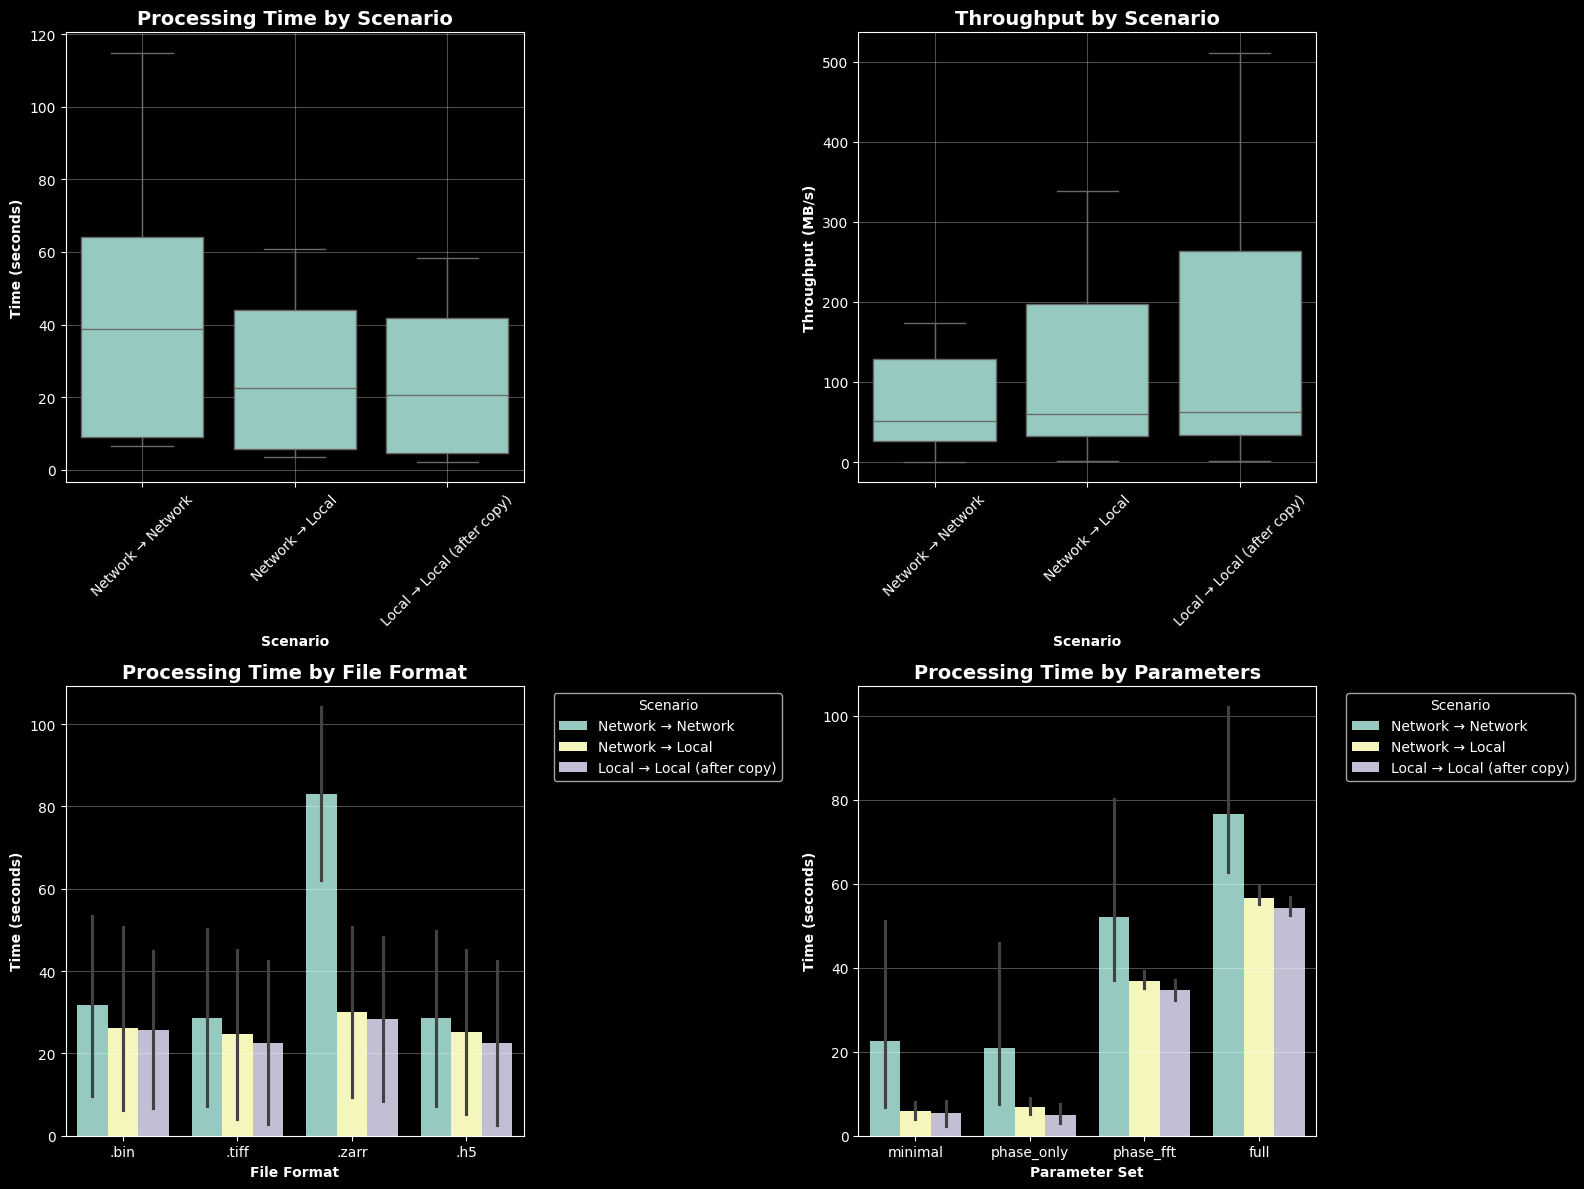

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Time comparison by scenario
ax = axes[0, 0]
sns.boxplot(data=df_all, x='scenario', y='time_sec', ax=ax)
ax.set_title('Processing Time by Scenario', fontsize=14, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontweight='bold')
ax.set_xlabel('Scenario', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 2. Throughput comparison by scenario
ax = axes[0, 1]
sns.boxplot(data=df_all, x='scenario', y='throughput_mb_per_sec', ax=ax)
ax.set_title('Throughput by Scenario', fontsize=14, fontweight='bold')
ax.set_ylabel('Throughput (MB/s)', fontweight='bold')
ax.set_xlabel('Scenario', fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 3. Time by file format
ax = axes[1, 0]
sns.barplot(data=df_all, x='format', y='time_sec', hue='scenario', ax=ax)
ax.set_title('Processing Time by File Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontweight='bold')
ax.set_xlabel('File Format', fontweight='bold')
ax.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# 4. Time by parameter set
ax = axes[1, 1]
sns.barplot(data=df_all, x='params', y='time_sec', hue='scenario', ax=ax)
ax.set_title('Processing Time by Parameters', fontsize=14, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontweight='bold')
ax.set_xlabel('Parameter Set', fontweight='bold')
ax.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(LOCAL_PATH / f"benchmark_plots_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

## Speedup Analysis


SPEEDUP ANALYSIS (relative to Network → Network)
                  scenario  mean_time_sec  speedup  percent_faster
Local → Local (after copy)      24.778831 1.734598       73.459811
           Network → Local      26.497522 1.622088       62.208803
         Network → Network      42.981314 1.000000        0.000000


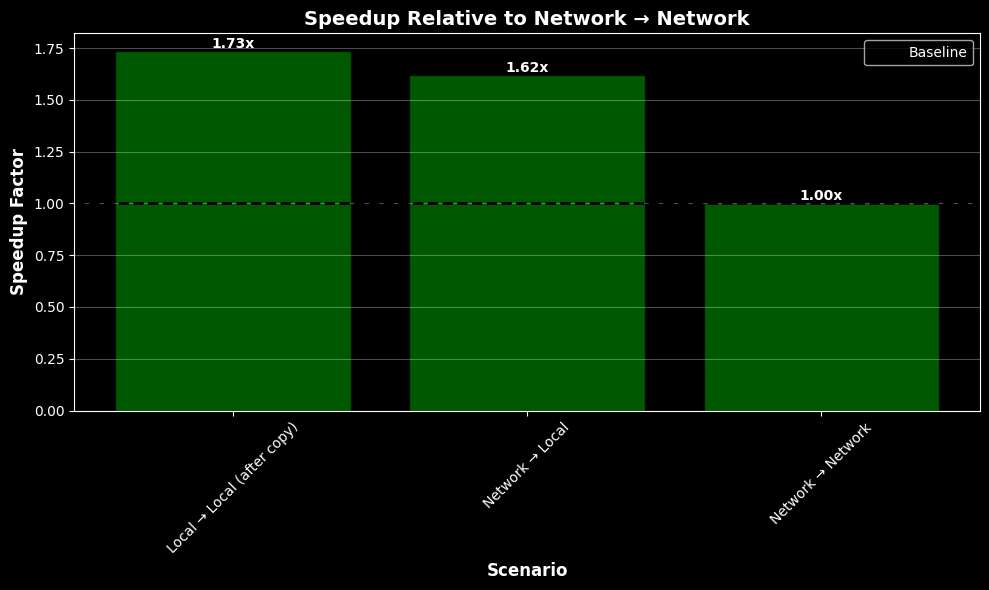

In [10]:
# Calculate speedup relative to Network → Network baseline
baseline = df_all[df_all['scenario'] == 'Network → Network']['time_sec'].mean()

speedup_data = []
for scenario in df_all['scenario'].unique():
    scenario_times = df_all[df_all['scenario'] == scenario]['time_sec']
    mean_time = scenario_times.mean()
    speedup = baseline / mean_time
    percent_faster = (speedup - 1) * 100

    speedup_data.append({
        'scenario': scenario,
        'mean_time_sec': mean_time,
        'speedup': speedup,
        'percent_faster': percent_faster
    })

df_speedup = pd.DataFrame(speedup_data).sort_values('speedup', ascending=False)

print("\n" + "="*80)
print("SPEEDUP ANALYSIS (relative to Network → Network)")
print("="*80)
print(df_speedup.to_string(index=False))

# Plot speedup
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_speedup['scenario'], df_speedup['speedup'],
              color=['red' if x < 1 else 'green' for x in df_speedup['speedup']],
              alpha=0.7, edgecolor='black')
ax.axhline(1, color='black', linestyle='--', linewidth=2, label='Baseline')
ax.set_ylabel('Speedup Factor', fontsize=12, fontweight='bold')
ax.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax.set_title('Speedup Relative to Network → Network', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add value labels on bars
for bar, speedup in zip(bars, df_speedup['speedup']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{speedup:.2f}x',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(LOCAL_PATH / f"speedup_analysis_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

## Recommendations

In [11]:
# Find best configurations
best_overall = df_all.loc[df_all['time_sec'].idxmin()]
best_throughput = df_all.loc[df_all['throughput_mb_per_sec'].idxmax()]

# Best by file format
best_by_format = df_all.groupby('format')['time_sec'].idxmin()
best_formats = df_all.loc[best_by_format]

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)

print("\n1. FASTEST OVERALL CONFIGURATION:")
print(f"   Scenario: {best_overall['scenario']}")
print(f"   Format: {best_overall['format']}")
print(f"   Parameters: {best_overall['params']}")
print(f"   Time: {best_overall['time_sec']:.2f}s")
print(f"   Throughput: {best_overall['throughput_mb_per_sec']:.2f}MB/s")

print("\n2. HIGHEST THROUGHPUT:")
print(f"   Scenario: {best_throughput['scenario']}")
print(f"   Format: {best_throughput['format']}")
print(f"   Parameters: {best_throughput['params']}")
print(f"   Throughput: {best_throughput['throughput_mb_per_sec']:.2f}MB/s")

print("\n3. BEST FILE FORMATS:")
for _, row in best_formats.iterrows():
    print(f"   {row['format']}: {row['time_sec']:.2f}s ({row['scenario']})")

print("\n4. WORKFLOW COMPARISON:")
net2net_avg = df_all[df_all['scenario'] == 'Network → Network']['time_sec'].mean()
net2local_avg = df_all[df_all['scenario'] == 'Network → Local']['time_sec'].mean()
local2local_avg = df_all[df_all['scenario'] == 'Local → Local (after copy)']['time_sec'].mean()

print(f"   Network → Network: {net2net_avg:.2f}s (avg)")
print(f"   Network → Local: {net2local_avg:.2f}s (avg)")
print(f"   Local → Local: {local2local_avg:.2f}s (avg, excluding copy time)")

if net2local_avg < net2net_avg:
    improvement = ((net2net_avg - net2local_avg) / net2net_avg) * 100
    print(f"\n   ✓ Writing to local is {improvement:.1f}% faster than network")
else:
    print(f"\n   ✗ Network storage is faster in this configuration")

# Check if copy + process is worth it
if len(results_copy_then_local) > 0 and results_copy_then_local[0]['success']:
    total_with_copy = results_copy_then_local[0]['total_time_sec']
    print(f"\n5. COPY STRATEGY:")
    print(f"   Copy time: {copy_time:.2f}s")
    print(f"   Total time (copy + process): {total_with_copy:.2f}s")
    if total_with_copy < net2net_avg:
        print(f"   ✓ Copying first is worth it for repeated processing")
    else:
        print(f"   ✗ Direct processing is faster for single runs")


RECOMMENDATIONS

1. FASTEST OVERALL CONFIGURATION:
   Scenario: Local → Local (after copy)
   Format: .h5
   Parameters: minimal
   Time: 2.25s
   Throughput: 511.19MB/s

2. HIGHEST THROUGHPUT:
   Scenario: Local → Local (after copy)
   Format: .h5
   Parameters: minimal
   Throughput: 511.19MB/s

3. BEST FILE FORMATS:
   .bin: 5.03s (Local → Local (after copy))
   .h5: 2.25s (Local → Local (after copy))
   .tiff: 2.35s (Local → Local (after copy))
   .zarr: 8.12s (Local → Local (after copy))

4. WORKFLOW COMPARISON:
   Network → Network: 42.98s (avg)
   Network → Local: 26.50s (avg)
   Local → Local: 24.78s (avg, excluding copy time)

   ✓ Writing to local is 38.4% faster than network

5. COPY STRATEGY:
   Copy time: 50.54s
   Total time (copy + process): 58.91s
   ✗ Direct processing is faster for single runs


## Cleanup (Optional)

Remove benchmark output files to free up space

In [4]:
# Uncomment to clean up test outputs
shutil.rmtree(OUTPUT_NETWORK)
shutil.rmtree(OUTPUT_LOCAL)
shutil.rmtree(RAW_TIFFS_LOCAL)
print("Cleanup complete")

Cleanup complete
